In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
train_img_path  = "../data/Training-Dataset/Images/"
train_mask_path = "../data/Training-Dataset/Masks-Ideal/"

In [3]:
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images[filename.split('.')[0]] = img  #remove extension from file name
    return images

In [4]:
images = load_images_from_folder(train_img_path)
masks  = load_images_from_folder(train_mask_path)

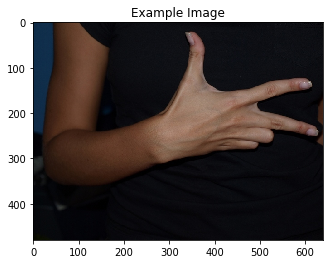

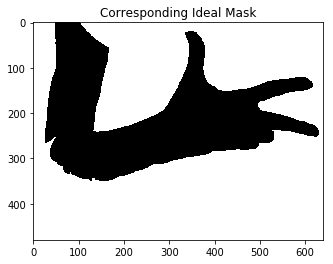

In [5]:
plt.title("Example Image")
plt.imshow(cv2.cvtColor(images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask")
plt.imshow(cv2.cvtColor(masks['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
def skinDetection(image, mask, value = 255):
    mask_skin = mask != 0
    img = image.copy()
    img[mask_skin]= value
    return img

In [7]:
skin_images = {}
for key in images.keys():
    skin_images[key] = skinDetection(images[key], masks[key])

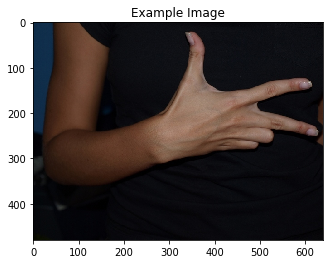

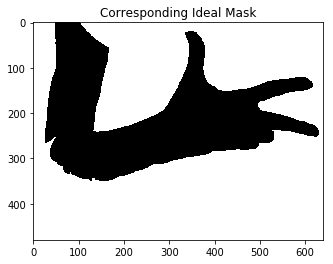

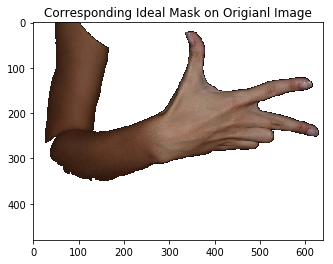

In [8]:
plt.title("Example Image")
plt.imshow(cv2.cvtColor(images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask")
plt.imshow(cv2.cvtColor(masks['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()
plt.title("Corresponding Ideal Mask on Origianl Image")
plt.imshow(cv2.cvtColor(skin_images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB))
plt.show()

In [45]:
def histogramCharacterization(image, channels, min_value, max_value, color_space, xbins, ybins = 0):
    if ybins == 0:
        ybins = xbins
    
    colors = ["r", "g", "b"]
    if color_space == "RGB":
        channel_histograms = []
        for wanted_channel in channels:
            img = image[:,:,wanted_channel]

            hist = cv2.calcHist([img], [0] , None, [xbins], [min_value, max_value])
            channel_histograms.extend(hist)

            # plot the histogram
            plt.plot(hist, color = colors[wanted_channel])
            plt.xlim([0, 256])
        return [h for h in channel_histograms]
   
    elif color_space == "YCrCb":
        minCr = image[:,:,1].min()
        maxCr = image[:,:,1].max()
        minCb = image[:,:,2].min()
        maxCb = image[:,:,2].max()
        hist = cv2.calcHist([image[:,:,1], image[:,:,2]], [0,1], None, [xbins, ybins], [min_value, max_value,min_value, max_value,])
        return hist, minCr, maxCr, minCb, maxCb

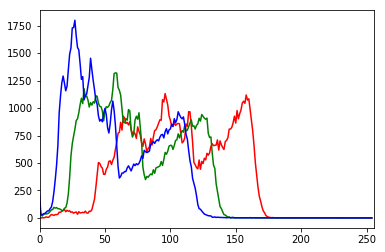

In [33]:
hist = histogramCharacterization(cv2.cvtColor(skin_images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2RGB), [0,1,2] , 0, 255, "RGB", 255)

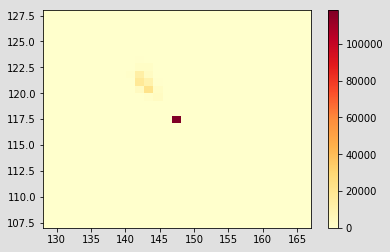

In [12]:
X, Y = np.meshgrid(xedges, yedges)

fig = plt.figure()
im = plt.pcolormesh(X, Y, hist, cmap = "YlOrRd")
fig.patch.set_facecolor('#E0E0E0')
plt.colorbar(im)
plt.show()

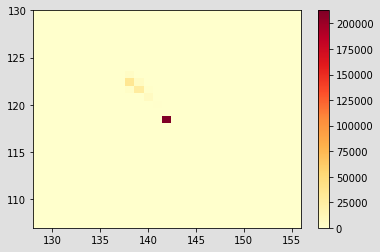

In [88]:
cr = cv2.cvtColor(skin_images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2YCrCb)[:,:,1]
cb = cv2.cvtColor(skin_images['3_P_hgr1_id05_3'], cv2.COLOR_BGR2YCrCb)[:,:,2]

minCr = cr.min()
maxCr = cr.max()
minCb = cb.min()
maxCb = cb.max()

xedges = np.linspace(minCr, maxCr, 30)
yedges = np.linspace(minCb, maxCb, 30)


X, Y = np.meshgrid(xedges, yedges)

fig = plt.figure()
im = plt.pcolormesh(X, Y, hist1, cmap = "YlOrRd")
fig.patch.set_facecolor('#E0E0E0')
plt.colorbar(im)
plt.show()

In [89]:
bins = 35
channels  = [2,3]
min_value = 60 
max_value = 200
global_min_xEdges = 999
global_max_xEdges = 0
global_min_yEdges = 999
global_max_yEdges = 0
bidimensional_histogram = x = [[0 for i in range(bins)] for j in range(bins)]

In [94]:
def AddHistogram(modelHist, summingHist, summingMinXEdge, summingMaxXEdge, summingMinYEdge, summingMaxYEdge):
    modelHist += summingHist
    global_min_xEdges_ = min(global_min_xEdges, summingMinXEdge)
    global_max_xEdges_ = max(global_max_xEdges, summingMaxXEdge)
    global_min_yEdges_ = min(global_min_yEdges, summingMinYEdge)
    global_max_yEdges_ = max(global_max_yEdges, summingMaxYEdge)    
    return modelHist, global_min_xEdges_, global_max_xEdges_, global_min_yEdges_, global_max_yEdges_

In [101]:
for key in skin_images.keys():
    image = skin_images[key].copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    histogram, minCr, maxCr, minCb, maxCb = histogramCharacterization(image, channels, min_value, max_value,"YCrCb", bins)
    bidimensional_histogram, global_min_xEdges, global_max_xEdges, global_min_YEdges, global_max_YEdges = AddHistogram(bidimensional_histogram, histogram ,minCr, maxCr, minCb, maxCb)
    
bidimensional_histogram /= len(skin_images)

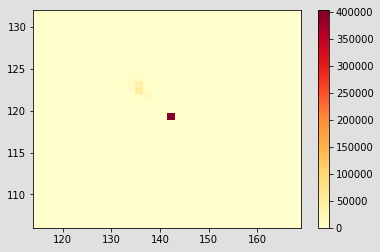

In [104]:
xedges = np.linspace(global_min_xEdges, global_max_xEdges, bins)
yedges = np.linspace(global_min_YEdges, global_max_YEdges, bins)

X, Y = np.meshgrid(xedges, yedges)

fig = plt.figure()
im = plt.pcolormesh(X, Y, bidimensional_histogram, cmap = "YlOrRd")
fig.patch.set_facecolor('#E0E0E0')
plt.colorbar(im)
plt.show()
